In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.5.0


In [ ]:
from pathlib import Path
from nyuv2 import *
from toolbox_nyu_depth_v2 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class MyModel():

    def __init__(self):
        '''
        Crear el modelos para segmentación
        '''
        self.input_rgb = tf.keras.layers.Input(shape=(640,480,3),dtype=tf.float32)
        self.input_depth = tf.keras.layers.Input(shape=(640,480,1),dtype=tf.float32)
        self.fusion_1 = None
        self.fusion_2 = None
        self.fusion_3 = None

    def rgbd_fusion(self,input_r,input_d,capa):
        r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
        r = tf.keras.layers.Reshape((1,1,64*capa))(r)
        r = tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
        r = tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
        m_1 = tf.keras.layers.Multiply()([input_r,r])
        
        d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
        d = tf.keras.layers.Reshape((1,1,64*capa))(d)
        d = tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
        d = tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
        m_2 = tf.keras.layers.Multiply()([input_d,d])
        
        return tf.keras.layers.Add()([m_1,m_2])

    def resnet_layer(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def resnet_layer_div(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same', strides=(2,1))(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same', strides=(1,2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)

        return x
    
    def bottleneck_layer(self,input_bo,filters):
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(input_bo)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_bo])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def decode_layer(self,input_de,input_add,filters):
        x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(input_de)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(x)
        x_2 = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), activation='relu', padding='same')(input_add)
        x = tf.keras.layers.Add()([x, x_2])

        return x
        
    def model(self):

        # Preparar la entrada de datos
        xr = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_rgb)
        xd = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_depth)

        # Fusion
        xr = self.rgbd_fusion(xr,xd,1)

        # Preparar para encoder
        xr = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xr)
        xd = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xd)

        ''' ENCODER'''
        # PRIMERA CAPA
        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,64)
            xd = self.resnet_layer(xd,xd,64)
            
        # Fusion dentro de Resnet
        xr = self.rgbd_fusion(xr,xd,1)
        self.fusion_1 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # SEGUNDA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xr),128)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xd),128)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,128)
            xd = self.resnet_layer(xd,xd,128)
            
        # Fusion dentro de Resnet
        xr = self.rgbd_fusion(xr,xd,2)
        self.fusion_2 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # TERCERA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2))(xr),256)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2))(xd),256)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,256)
            xd = self.resnet_layer(xd,xd,256)
            
        # Fusion dentro de Resnet
        xr = self.rgbd_fusion(xr,xd,4)
        self.fusion_3 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # CUARTA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2))(xr),512)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2))(xd),512)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,512)
            xd = self.resnet_layer(xd,xd,512)
            
        # Fusion dentro de Resnet
        xr = self.rgbd_fusion(xr,xd,8)

        '''DECODER'''

        xr = self.decode_layer(xr,self.fusion_3,512)
        xr = self.decode_layer(xr,self.fusion_2,256)
        xr = self.decode_layer(xr,self.fusion_1,128)
        
        xr = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(xr)

        return tf.keras.Model(inputs=[self.input_rgb, self.input_depth], outputs=xr)



       



In [3]:
model = MyModel().model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 480, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 640, 480, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 240, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 240, 64) 3200        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
tf.keras.metrics.MeanIoU(num_classes, name=None, dtype=None)

In [22]:
labels = pd.read_csv('label_names.csv',header=None)
label_names = {}
for i in labels[0]:
    label_names[i.split(';')[0]] = i.split(';')[1].split("'")[1]

In [5]:
DATASET_DIR = Path('dataset')
labeled = LabeledDataset(DATASET_DIR / 'nyu_depth_v2_labeled.mat')

x = []
y = []
for i in range(1449):
    color, depth, label = labeled[i]
    x.append([color,depth])
    y.append(label)

In [7]:
print(x[0])
print(y[0])

[<PIL.Image.Image image mode=RGB size=640x480 at 0x223E22F7340>, <PIL.Image.Image image mode=F size=640x480 at 0x223E27E96A0>]
<PIL.Image.Image image mode=I;16 size=640x480 at 0x223E27E9B80>


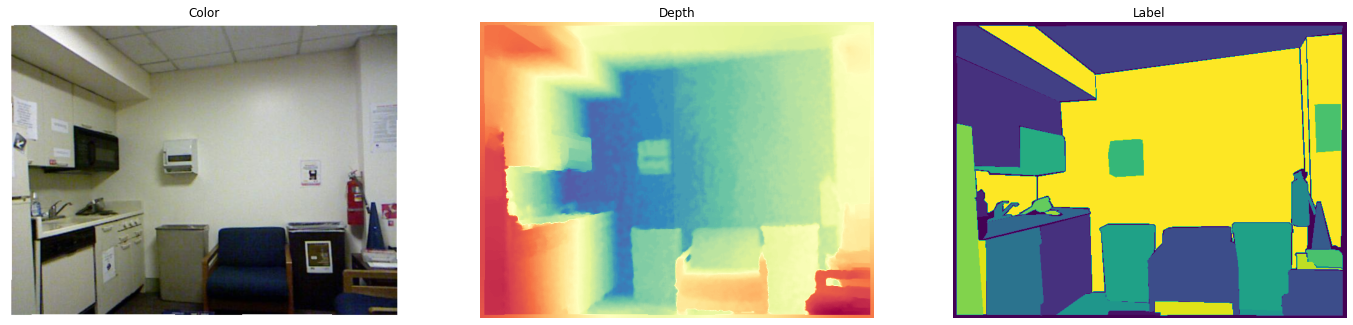

In [9]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, x[0][0])

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, np.asarray(x[0][1]))

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, np.asarray(y[0]))

plt.show()